In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve

from mlxtend.classifier import StackingClassifier

from xgboost import XGBRFClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE, ADASYN

In [3]:

train_data = pd.read_csv('E:/ML_IP/ML_projects/datastorm/credit_card_default_train.csv')
test_data = pd.read_csv('E:/ML_IP/ML_projects/datastorm/credit_card_default_test.csv')

In [4]:
cat_cols = ['Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE','PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']
target = 'NEXT_MONTH_DEFAULT'
ID = 'Client_ID'
num_cols = [col for col in train_data.columns.tolist() if col not in cat_cols +[target]+[ID]]

In [5]:
num_cols

['Balance_Limit_V1',
 'DUE_AMT_JULY',
 'DUE_AMT_AUG',
 'DUE_AMT_SEP',
 'DUE_AMT_OCT',
 'DUE_AMT_NOV',
 'DUE_AMT_DEC',
 'PAID_AMT_JULY',
 'PAID_AMT_AUG',
 'PAID_AMT_SEP',
 'PAID_AMT_OCT',
 'PAID_AMT_NOV',
 'PAID_AMT_DEC']

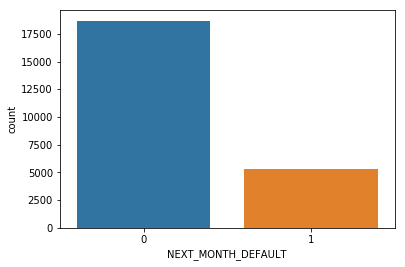

In [6]:
sns.countplot(x=target, data=train_data)

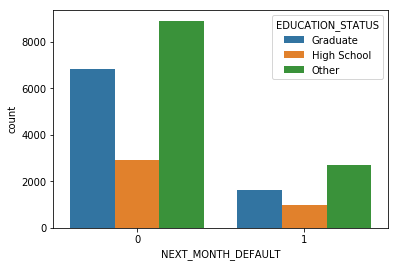

In [7]:
sns.countplot(x=target, data=train_data, hue ='EDUCATION_STATUS')

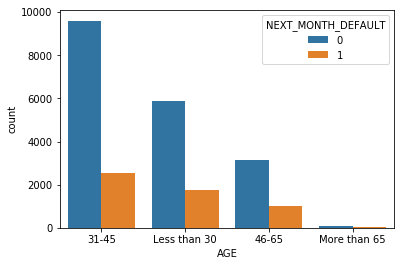

In [8]:
sns.countplot(x='AGE', data=train_data, hue =target)

In [9]:
def Paid_Due_July(row):
    if row['PAID_AMT_JULY'] == 0:
        val = row['DUE_AMT_JULY']
    else:
        val = row['DUE_AMT_JULY']/row['PAID_AMT_JULY']
    return val

def Paid_Due_Aug(row):
    if row['PAID_AMT_AUG'] == 0:
        val = row['DUE_AMT_AUG']
    else:
        val = row['DUE_AMT_AUG']/row['PAID_AMT_AUG']
    return val

def Paid_Due_Sep(row):
    if row['PAID_AMT_SEP'] == 0:
        val = row['DUE_AMT_SEP']
    else:
        val = row['DUE_AMT_SEP']/row['PAID_AMT_SEP']
    return val

def Paid_Due_Oct(row):
    if row['PAID_AMT_OCT'] == 0:
        val = row['DUE_AMT_OCT']
    else:
        val = row['DUE_AMT_OCT']/row['PAID_AMT_OCT']
    return val

def Paid_Due_Nov(row):
    if row['PAID_AMT_NOV'] == 0:
        val = row['DUE_AMT_NOV']
    else:
        val = row['DUE_AMT_NOV']/row['PAID_AMT_NOV']
    return val

def Paid_Due_Dec(row):
    if row['PAID_AMT_DEC'] == 0:
        val = row['DUE_AMT_DEC']
    else:
        val = row['DUE_AMT_DEC']/row['PAID_AMT_DEC']
    return val

In [10]:
train_data['PAID_DUE_JULY'] = train_data.apply(Paid_Due_July, axis=1)
train_data['PAID_DUE_AUG'] = train_data.apply(Paid_Due_Aug, axis=1)
train_data['PAID_DUE_SEP'] = train_data.apply(Paid_Due_Sep, axis=1)
train_data['PAID_DUE_OCT'] = train_data.apply(Paid_Due_Oct, axis=1)
train_data['PAID_DUE_NOV'] = train_data.apply(Paid_Due_Nov, axis=1)
train_data['PAID_DUE_DEC'] = train_data.apply(Paid_Due_Dec, axis=1)

test_data['PAID_DUE_JULY'] = test_data.apply(Paid_Due_July, axis=1)
test_data['PAID_DUE_AUG'] = test_data.apply(Paid_Due_Aug, axis=1)
test_data['PAID_DUE_SEP'] = test_data.apply(Paid_Due_Sep, axis=1)
test_data['PAID_DUE_OCT'] = test_data.apply(Paid_Due_Oct, axis=1)
test_data['PAID_DUE_NOV'] = test_data.apply(Paid_Due_Nov, axis=1)
test_data['PAID_DUE_DEC'] = test_data.apply(Paid_Due_Dec, axis=1)

In [11]:
train_data['PAY_TOT'] = train_data['PAY_JULY'] + train_data['PAY_AUG'] + train_data['PAY_SEP'] + train_data['PAY_OCT'] + train_data['PAY_NOV'] + train_data['PAY_DEC']
test_data['PAY_TOT'] = test_data['PAY_JULY'] + test_data['PAY_AUG'] + test_data['PAY_SEP'] + test_data['PAY_OCT'] + test_data['PAY_NOV'] + test_data['PAY_DEC']

In [12]:
def isZero(row):
    if row['PAY_TOT'] == 0:
        val = 1
    else:
        val = 0
    return val

In [13]:
train_data['PAY_TOT_0'] = train_data.apply(isZero, axis=1)
test_data['PAY_TOT_0'] = test_data.apply(isZero, axis=1)

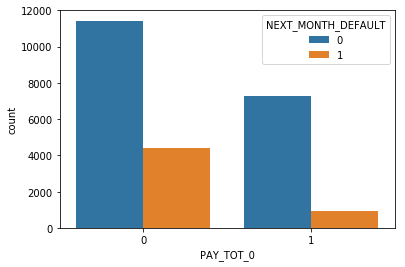

In [14]:
sns.countplot(x = 'PAY_TOT_0',data=train_data,hue=target)

In [15]:
train_data.head()

,Client_ID,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,...,PAID_AMT_DEC,NEXT_MONTH_DEFAULT,PAID_DUE_JULY,PAID_DUE_AUG,PAID_DUE_SEP,PAID_DUE_OCT,PAID_DUE_NOV,PAID_DUE_DEC,PAY_TOT,PAY_TOT_0
0,A2,1M,M,Graduate,Other,31-45,-1,-1,-1,-1,...,538165,0,0.945010,0.564457,0.152316,0.242167,162772.000000,-0.025981,-6,0
1,A3,1M,F,High School,Other,Less than 30,0,-1,-1,-1,...,33666,0,2.327464,3.286104,0.619067,0.538664,85.786624,3.700766,-4,0
2,A4,100K,F,High School,Single,31-45,4,3,2,2,...,0,1,16681.000000,16082.000000,15477.000000,0.000000,0.000000,0.000000,7,0
3,A5,200K,F,Graduate,Single,31-45,2,0,0,0,...,3918,1,23.464851,23.868380,25.755682,21.062554,24.784638,26.222563,2,0
4,A6,1M,F,Graduate,Other,31-45,2,2,0,0,...,17325,0,429556.000000,20.176335,26.579159,25.128658,27.149015,26.199076,4,0


In [16]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)

train_df = pd.DataFrame(enc.fit_transform(train_data[['Balance_Limit_V1','EDUCATION_STATUS','MARITAL_STATUS','AGE','Gender']]).toarray())

enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)

test_df = pd.DataFrame(enc.fit_transform(test_data[['Balance_Limit_V1','EDUCATION_STATUS','MARITAL_STATUS','AGE','Gender']]).toarray())

In [17]:
train_data = pd.concat([train_data,train_df],axis=1)
test_data = pd.concat([test_data,test_df],axis=1)

In [18]:
LabelEncoder = LabelEncoder()
train_data['Balance_Limit_V1_cat'] = LabelEncoder.fit_transform(train_data['Balance_Limit_V1'])
train_data['Gender_cat'] = LabelEncoder.fit_transform(train_data['Gender'])
train_data['EDUCATION_STATUS_cat'] = LabelEncoder.fit_transform(train_data['EDUCATION_STATUS'])
train_data['MARITAL_STATUS_cat'] = LabelEncoder.fit_transform(train_data['MARITAL_STATUS'])
train_data['AGE_cat'] = LabelEncoder.fit_transform(train_data['AGE'])

test_data['Balance_Limit_V1_cat'] = LabelEncoder.fit_transform(test_data['Balance_Limit_V1'])
test_data['Gender_cat'] = LabelEncoder.fit_transform(test_data['Gender'])
test_data['EDUCATION_STATUS_cat'] = LabelEncoder.fit_transform(test_data['EDUCATION_STATUS'])
test_data['MARITAL_STATUS_cat'] = LabelEncoder.fit_transform(test_data['MARITAL_STATUS'])
test_data['AGE_cat'] = LabelEncoder.fit_transform(test_data['AGE'])

In [19]:
train_data

,Client_ID,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,...,14,15,16,17,18,Balance_Limit_V1_cat,Gender_cat,EDUCATION_STATUS_cat,MARITAL_STATUS_cat,AGE_cat
0,A2,1M,M,Graduate,Other,31-45,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,1.0,3,1,0,0,0
1,A3,1M,F,High School,Other,Less than 30,0,-1,-1,-1,...,0.0,1.0,0.0,1.0,0.0,3,0,1,0,2
2,A4,100K,F,High School,Single,31-45,4,3,2,2,...,0.0,0.0,0.0,1.0,0.0,2,0,1,1,0
3,A5,200K,F,Graduate,Single,31-45,2,0,0,0,...,0.0,0.0,0.0,1.0,0.0,5,0,0,1,0
4,A6,1M,F,Graduate,Other,31-45,2,2,0,0,...,0.0,0.0,0.0,1.0,0.0,3,0,0,0,0
5,A8,400K,F,Graduate,Single,31-45,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,7,0,0,1,0
6,A9,100K,M,Other,Single,Less than 30,1,2,2,2,...,0.0,1.0,0.0,0.0,1.0,2,1,2,1,2
7,A11,100K,F,High School,Other,Less than 30,2,2,2,0,...,0.0,1.0,0.0,1.0,0.0,2,0,1,0,2
8,A12,500K,M,Other,Other,31-45,0,0,0,2,...,0.0,0.0,0.0,0.0,1.0,0,1,2,0,0
9,A13,1M,M,Other,Single,46-65,0,0,2,0,...,1.0,0.0,0.0,0.0,1.0,3,1,2,1,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop([target,ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1), 
                                                    train_data[target], test_size=0.30)

In [21]:
X_train.shape,y_train.shape

((16800, 50), (16800,))

In [24]:
%store X_train
%store X_test
%store y_train
%store y_test
%store test_data
%store train_data
X_train.to_csv("data_lgbm/X_train.csv",index=1)
X_test.to_csv("data_lgbm/X_test.csv",index=1)
y_train.to_csv("data_lgbm/y_train.csv",index=1)
y_test.to_csv("data_lgbm/y_test.csv",index=1)


check = pd.read_csv("data_lgbm/y_train.csv")
check2 = pd.read_csv("data_lgbm/X_train.csv")


Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'test_data' (DataFrame)
Stored 'train_data' (DataFrame)


C:\Users\Udith\anaconda_\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':
C:\Users\Udith\anaconda_\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


In [340]:
check.shape,check2.shape

((16799, 2), (16800, 51))

In [312]:
#param_grid = {'bootstrap': [True, False],
# 'max_features': ['auto', 'sqrt'],
# 'n_estimators': [100,150,200]}
model_rf = RandomForestClassifier(n_estimators=100,criterion='entropy')
#model_rf.fit(train_data.drop([target,ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1),train_data[target])
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [313]:
#preds_rf = model_rf.predict(test_data.drop([ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1))
preds_rf = model_rf.predict(X_test)

In [315]:
preds_rf

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [314]:
print(classification_report(y_test,preds_rf))
print ('\n')
print(confusion_matrix(y_test,preds_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5613
           1       0.63      0.36      0.46      1587

    accuracy                           0.81      7200
   macro avg       0.74      0.65      0.67      7200
weighted avg       0.79      0.81      0.79      7200



[[5281  332]
 [1014  573]]


In [264]:
model_ada = AdaBoostClassifier(n_estimators=200,learning_rate = 0.01)
#model_ada.fit(X_train,y_train)
model_ada.fit(train_data.drop([target,ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1),train_data[target])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=200, random_state=None)

In [267]:
preds_ada = model_ada.predict(X_test)


In [268]:
print(classification_report(y_test,preds_ada))
print ('\n')
print(confusion_matrix(y_test,preds_ada))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5634
           1       0.69      0.29      0.41      1566

    accuracy                           0.82      7200
   macro avg       0.76      0.63      0.65      7200
weighted avg       0.80      0.82      0.79      7200



[[5425  209]
 [1106  460]]


In [286]:
import xgboost
model_xgb = xgboost.XGBClassifier()
model_xgb.fit(X_train,y_train)
cross_val_score(model_xgb,train_data.drop([target,ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1),train_data[target],cv=5)

array([0.80479167, 0.81166667, 0.82125   , 0.83520833, 0.82354167])

In [318]:
preds_xgb = model_xgb.predict(X_test)

In [319]:
preds_xgb

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [288]:
print(classification_report(y_test,preds_xgb))
print ('\n')
print(confusion_matrix(y_test,preds_xgb))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5634
           1       0.66      0.35      0.45      1566

    accuracy                           0.82      7200
   macro avg       0.75      0.65      0.67      7200
weighted avg       0.80      0.82      0.80      7200



[[5349  285]
 [1022  544]]


In [275]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'rf'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = 0.5
params['feature_fraction'] = 0.8
params['bagging_freq'] = 1
params['num_leaves'] = 24
params['min_data'] = 50
params['max_depth'] = 10
params['max_bin']=20

params_best = {}
params_best['learning_rate'] = 0.1
params_best['boosting_type'] = 'dart'
params_best['objective'] = 'binary'
params_best['metric'] = 'binary_logloss'
params_best['sub_feature'] = 0.5
params_best['num_leaves'] = 18
params_best['min_data'] = 70
params_best['max_depth'] = 5
params_best['max_bin']=250
params_best['n_estimators']=110
params_best['colsample_bytree' ]=0
params_best['subsample']=0.000001

clf = lgb.train(params_best, d_train, 150)
clf1 = lgb.train(params, d_train, 150)

In [276]:
preds_lgb = clf.predict(X_test)
def avoid_prob(preds_lgb):
    for i in range(len(preds_lgb)):
        if preds_lgb[i]>=0.5:       # setting threshold to .5
            preds_lgb[i]=1
        else:
            preds_lgb[i]=0
    return preds_lgb
preds_lgb=avoid_prob(preds_lgb)

In [277]:
print(classification_report(y_test,preds_lgb))
print ('\n')
print(confusion_matrix(y_test,preds_lgb))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5634
           1       0.67      0.36      0.47      1566

    accuracy                           0.82      7200
   macro avg       0.75      0.65      0.68      7200
weighted avg       0.80      0.82      0.80      7200



[[5352  282]
 [1003  563]]


In [ ]:
print(classification_report(y_test,preds_lgb))
print ('\n')
print(confusion_matrix(y_test,preds_lgb))

In [ ]:
sample_submission = pd.DataFrame(columns=[ID,target])

In [211]:
avoid_prob(clf.predict(test_data.drop([ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1))).shape

(6000,)

In [212]:
sample_submission[ID]=test_data[ID]
sample_submission[target] = avoid_prob(clf.predict(test_data.drop([ID,'Balance_Limit_V1','Gender','EDUCATION_STATUS','MARITAL_STATUS','AGE'],axis=1)))

In [289]:
sample_submission.set_index(ID)

,NEXT_MONTH_DEFAULT
Client_ID,
A20170,0.0
A16887,0.0
A3430,0.0
A3696,0.0
A20474,0.0
A24270,0.0
A3052,1.0
A11159,0.0
A8192,0.0


In [226]:
submission = sample_submission.to_csv('data-storm-day2-2.csv',index = None)